# Analysis of kMC trajectories

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import sqlite3
import pandas as pd

## MD trajectory concentration as baseline

In [3]:
def MD_baseline(cluster_file_in, active_sites_file):
    """
    Extract MD trajectory concentrations for DPA clusters and top 20 species with highest concentration.

    Parameters:
        cluster_file_in (str): Path to DPA labels for MD trajectory.
        active_sites_file (str): Path to file with active sites in MSMs.
    """
    data = np.load(cluster_file_in)
    data = data.reshape((200, 16080))
    active_sites = np.load(active_sites_file)

    # unique cluster labels
    max_cluster = np.max(data.flatten())

    concentration = np.array([ [np.where(data[frame] == i)[0].shape[0] for i in range(max_cluster+1)] for frame in range(200)])[:, active_sites]

    # calculate average concentrations across all frames for ranking
    average_concentration = np.average(concentration, axis = 0)

    # select the 20 clusters with the highest average concentrations
    top_20_labels = np.argsort(average_concentration)[-20:][::-1]

    return top_20_labels, concentration


In [4]:
def process_spparks(file_path):
    """
    Convert SPPARKS .out file into arrays of concentrations and times.

    Parameters: 
        file_path (str): Path to spparks .out file.
    """
    species_data = []
    times = []

    # open and process the file
    with open(file_path, "r") as file:
        for line in file:
            
            parts = line.split()

            # skip header or non-data lines
            if parts[0] == "Loop":
                break
            if parts[0] == "Time" or parts[0] in ["Time", "SPPARKS", "Setting", "Running", "Memory"]:
                continue
            
            parts = line.split()
            
            # extract time and species concentrations
            species_counts = parts[2:-1] 
            species_data.append(list(map(int, species_counts)))
            times.append(parts[0])

    species_array = np.array(species_data)
    return np.array(species_array), np.array(times)


In [ ]:
def create_active_site_mapping(cluster_file, active_sites_file):
    """
    Create mapping between DPA labels and active site indices.

    Parameters:
        cluster_file (str): Path to file of DPA clusters.
        active_sites_file (str): Path to file of active sites in MSMs.
    """
    # mapping between original dpa labels and those of active sites
    dpa_labels = np.load(cluster_file)
    original = np.arange(0, np.max(dpa_labels) + 1, 1)
    assert(np.max(original) == np.max(dpa_labels))

    active_sites = np.load(active_sites_file)

    count = 0
    mapping = {}
    for site in original:
        if(site not in active_sites):
            count += 1
        mapping[site] = count
        count += 1
    return mapping

In [ ]:
# consistent plotting settings
from matplotlib.ticker import MultipleLocator
plt.rcParams.update({"font.size": 16})
plt.rcParams.update({"font.family": "Helvetica"})
plt.rcParams.update({"font.style": "normal"})
plt.minorticks_on()

## Code for figure 3

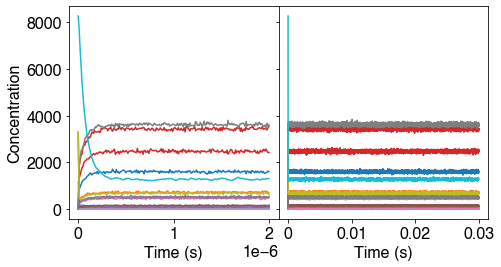

In [17]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# list of file names
file_names = [
    "spparks_results/spparks_out/20ns_100ps_5_200ns.out",
    "spparks_results/spparks_out/20ns_100ps_5_1s_final.out",
]

# create a GridSpec layout
fig = plt.figure(figsize=(15, 4))
gs = GridSpec(1, 4, width_ratios=[1, 1, 1, 1], wspace=0) 

# create axes with shared y-axes within groups
axs = [
    fig.add_subplot(gs[0]),
    fig.add_subplot(gs[1]),
]

axs[0].get_shared_y_axes().join(axs[0], axs[1])

# create a list to collect legend handles and labels
handles, labels = [], []

# iterate through each file and plot on corresponding subplot
for idx, name in enumerate(file_names):
    spparks_con, times = process_spparks(name)
    times_floats = (np.array([float(time) for time in times])*100)
    times_floats[0] = 0

    for i, label in enumerate(range(spparks_con.shape[1])):
        line, = axs[idx].plot(times_floats, spparks_con[:, label], label=f"Cluster {label}")
        if idx == 0:  # collect legend information only from the first subplot
            handles.append(line)
            labels.append(f"Cluster {label}")

    # set titles and labels for each subplot
    axs[idx].set_xlabel("Time (s)")
    if idx == 0:
        axs[idx].set_ylabel("Concentration")
    else:
        axs[idx].set_yticklabels([])  # remove y-axis labels

axs[idx].set_xticks(np.linspace(times_floats[0], times_floats[-1], 4))
axs[idx].set_xticklabels(["0", "0.01", "0.02", "0.03"]) # 0 instead of 0.000

plt.tight_layout() 
plt.subplots_adjust(right=0.85) 
plt.show()


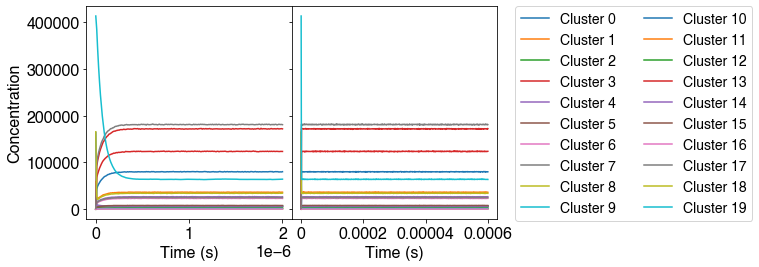

In [21]:
# list of file names
file_names = [
              "spparks_results/spparks_out/20ns_100ps_5_50x.out", 
             "spparks_results/spparks_out/20ns_100ps_5_1s_50x_final.out"
]

# create a GridSpec layout
fig = plt.figure(figsize=(15, 4))
gs = GridSpec(1, 4, width_ratios=[1, 1, 1, 1], wspace=0)  # wspace for spacing between groups

# create axes with shared y-axes within groups
axs = [
    fig.add_subplot(gs[0]),
    fig.add_subplot(gs[1]),
]

axs[0].get_shared_y_axes().join(axs[0], axs[1])

# create a list to collect legend handles and labels
handles, labels = [], []

# iterate through each file and plot on corresponding subplot
for idx, name in enumerate(file_names):
    spparks_con, times = process_spparks(name)
    times_floats = (np.array([float(time) for time in times])*100)
    times_floats[0] = 0

    for i, label in enumerate(range(spparks_con.shape[1])):
        line, = axs[idx].plot(times_floats, spparks_con[:, label], label=f"Cluster {label}")
        if idx == 0:  # collect legend information only from the first subplot
            handles.append(line)
            labels.append(f"Cluster {label}")

    # set titles and labels for each subplot
    axs[idx].set_xlabel("Time (s)")
    if idx == 0:
        axs[idx].set_ylabel("Concentration")
    else:
        axs[idx].set_yticklabels([])  # remove y-axis

axs[idx].set_xticks(np.linspace(times_floats[0], times_floats[-1], 4))  
axs[idx].set_xticklabels(["0", "0.0002", "0.00004", "0.0006"])

# add a single legend to the right of the last subplot
fig.legend(handles, labels, loc="center left", ncol=2, bbox_to_anchor=(0.48, 0.568), fontsize=14)

plt.tight_layout()  
plt.subplots_adjust(right=0.85) 
plt.show()


In [8]:
# Z = 3.5
cluster_file_in = "../clustering/results/dpa_inter/20ns_interval_100ps_64_ACE_torch_Z_3.5_isHalo_False_maxk_50_rmax_6.0_lmax_3_nmax_2.npy"
active_sites_file = "spparks_results/active_sites/active_states_3.5.npy"
mapping_lag1 = create_active_site_mapping(cluster_file_in, active_sites_file)
top_20_lag1, concentrations = MD_baseline(cluster_file_in, active_sites_file)
spparks_con_20ns, times = process_spparks("spparks_results/spparks_out/20ns_100ps_3.5.out")
spparks_con_200ns, times = process_spparks("spparks_results/spparks_out/20ns_100ps_3.5_200ns.out")

In [9]:
# stationary distribution
stat = np.load("spparks_results/spparks_out/pi_Bayesian_3.5.npy")

# lag = 10, lag 25
cluster_file_in = "../clustering/results/dpa_inter/20ns_interval_100ps_64_ACE_torch_Z_3.5_isHalo_False_maxk_50_rmax_6.0_lmax_3_nmax_2.npy"
active_sites_file = "spparks_results/active_sites/active_states_lag10.npy"
mapping_lag10 = create_active_site_mapping(cluster_file_in, active_sites_file)
top_20_lag10, _ = MD_baseline(cluster_file_in, active_sites_file)
spparks_con_20ns_lag10, times = process_spparks("spparks_results/spparks_out/20ns_100ps_3.5_lag10.out")

active_sites_file = "spparks_results/active_sites/active_states_lag25.npy"
mapping_lag25 = create_active_site_mapping(cluster_file_in, active_sites_file)
top_20_lag25, _ = MD_baseline(cluster_file_in, active_sites_file)
spparks_con_20ns_lag25, times = process_spparks("spparks_results/spparks_out/20ns_100ps_3.5_lag25.out")

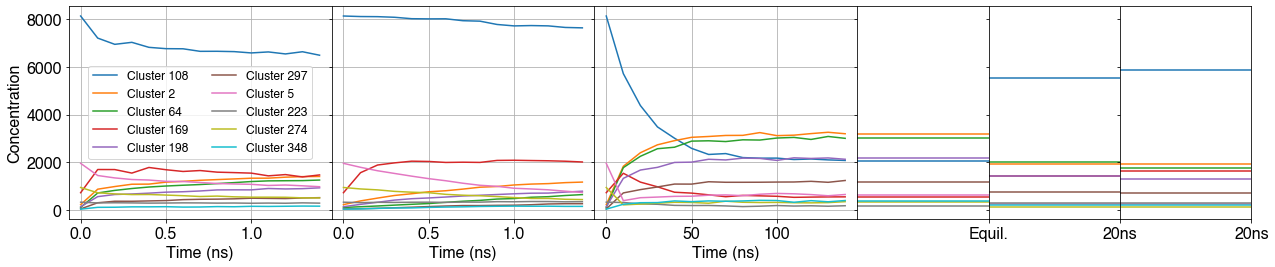

In [22]:
# create a colormap for consistent coloring between the plots
colormap_name = 'tab10'
cmap = plt.get_cmap(colormap_name)

# generate colors for the clusters
colors = cmap(np.linspace(0, 1, len(top_20_lag1[:10])))

# create a GridSpec layout
fig = plt.figure(figsize=(18, 4))
gs = fig.add_gridspec(1, 6, width_ratios=[1, 1, 1, 0.5, 0.5, 0.5])

# MD concentration
ax0 = fig.add_subplot(gs[0])
for i, label in enumerate(top_20_lag1[:10]):
    ax0.plot(np.arange(0, 15, 1) / 10, concentrations[:15, label], label=f"Cluster {label}", color=colors[i])
ax0.set_xlabel("Time (ns)")
ax0.set_ylabel("Concentration")
ax0.legend(loc='center', ncol=2, fontsize=12)
ax0.grid(True)

# kMC 20 ns concentration
ax1 = fig.add_subplot(gs[1], sharey=ax0) 
for i, label in enumerate(top_20_lag1[:10]):
    ax1.plot(np.arange(0, 15, 1) / 10, spparks_con_20ns[:15, label], color=colors[i])
ax1.set_xlabel("Time (ns)")
ax1.grid(True)
plt.setp(ax1.get_yticklabels(), visible=False)  

# kMC 200 ns concentration
ax2 = fig.add_subplot(gs[2], sharey=ax0)  
for i, label in enumerate(top_20_lag1[:10]):
    ax2.plot(np.arange(0, 15, 1) *100 / 10, spparks_con_200ns[:15, label], color=colors[i])
ax2.set_xlabel("Time (ns)")
ax2.grid(True)
plt.setp(ax2.get_yticklabels(), visible=False) 

# stationary sites
ax3 = fig.add_subplot(gs[3], sharey=ax0)  
for i, label in enumerate(top_20_lag1[:10]):
    ax3.axhline(y=stat[label] * 16042, linestyle='-', color=colors[i])
ax3.set_xticks([1])
ax3.set_xticklabels(["Equil."])
plt.setp(ax3.get_yticklabels(), visible=False)  

# lag 10
ax4 = fig.add_subplot(gs[4], sharey=ax0)  
for i, label in enumerate(top_20_lag10[:10]):
    ax4.axhline(y=spparks_con_20ns_lag10[-1, label], linestyle='-', color=colors[i])
ax4.set_xticks([1])
ax4.set_xticklabels(["20ns"])
plt.setp(ax4.get_yticklabels(), visible=False) 

# lag 25
ax5 = fig.add_subplot(gs[5], sharey=ax0)  
for i, label in enumerate(top_20_lag25[:10]):
    ax5.axhline(y=spparks_con_20ns_lag25[-1, label], linestyle='-', color=colors[i])
ax5.set_xticks([1])
ax5.set_xticklabels(["20ns"])
plt.setp(ax5.get_yticklabels(), visible=False)  

# adjust layout
plt.tight_layout()
plt.subplots_adjust(wspace=0)  
plt.show()
